# What this notebook does:

- Finds out if a particular signaling program is induced in the Chronic Obstructive Pulmonary Disease (COPD) dataset (GEO ID: GSE136831) by:
    - calculating program expression in cells from control and disease donors in the dataset.
    - finding fold change of program expression between disease versus control cells in different cell types. 
- For detailed method description, see manuscript McCauley/Kukreja et. al. 2024 method's section: "Enrichment of signaling programs in disease"

# Set up 

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as pl, scipy.sparse as ssp
import scanpy as sc,scanpy.external as sce
import sys
sys.path.append('../../helper_functions/')
import helper_functions_py3 as hf

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100)  # low dpi (dots per inch) yields small inline figures

import random
import scipy.stats  as ss
import statsmodels.stats.multitest as multitest
from matplotlib.patches import Rectangle
import seaborn as sn

# Load data

## COPD data

In [2]:
# load annData object for disease data:
# update this with the path where your anndata objects are stored !!
ß
anndata_path = '../../data/anndata_objects/'
adata = sc.read_h5ad(anndata_path + 'adata_copd_epithelial_processed.h5ad')

# subset disease datasets:
adata_ctrl = adata[adata.obs['"Disease_Identity"'] == '"Control"'].copy()
adata_disease = adata[adata.obs['"Disease_Identity"'] == '"COPD"'].copy()


## cNMF data

In [3]:
# load gene program data, also called the spectra matrix:

# this is gene x programs matrix with a weight for every gene 
# for each of the gene expression programs

cnmf_dir = '../../data/cnmf/'

spectra = pd.read_csv(cnmf_dir+'program_weights.csv', sep=',', index_col=0).T


In [4]:
# subset genes to only include the ones in disease dataset:
gene_subset_mask = np.in1d(spectra.columns, adata.var_names)
spectra_subset = spectra[spectra.columns[gene_subset_mask]]


In [5]:
# re-normalize spectra since some of the genes were removed:
spectra_subset_new = pd.DataFrame(np.array(spectra_subset)/np.array(spectra_subset.sum(1))[:,np.newaxis])
spectra_subset_new.columns = spectra_subset.columns
spectra_subset_new.index = spectra_subset.index


# Find expression of programs in disease versus control states

## Make matrix of top genes for every program

In [6]:
# input:

num_genes = 20
prog_names = np.array(['Shared-1', 'Shared-2', 'Shared-3', 'CHIR', 'IL13','IFNA', 
                          'IFNG-1', 'IFNG-2', 'IFNG-3', 'TGFB1-1', 'TGFB1-2'])
prog_genes = np.zeros((num_genes, prog_names.shape[0]), dtype = object)

for i,programs in enumerate(prog_names):
    prog_genes[:,i] = np.array(spectra_subset.loc[programs].sort_values(ascending = False).index[:num_genes])

prog_genes_pd = pd.DataFrame(prog_genes)  
prog_genes_pd.columns = prog_names

## Find fold change expression

In [7]:
# function to find expression of program in a cell with the given gene list:

def program_expr_cp10k(adata, spectra, gene_list, program ):
    
    # subset expression for the gene list. Also add pseudo count (for fold change later)
    E = adata[:,gene_list].copy().layers['raw_counts'].todense().A+0.01
    
    # subset loads for the particular gene_list and program
    loadings = np.array(spectra[gene_list].loc[program]) 
    
    # renormalize loadings to sum to 1
    loadings = loadings/sum(loadings) 
    
    # calculate expression x loadings to get program expression:
    if ssp.issparse(E):
        prog_exp =(E.todense().A*loadings).sum(axis=1)
    else:
        prog_exp = np.sum(E*loadings, axis = 1)
    return prog_exp


In [8]:
fc_all = {}
pval_all = {}
rand_num = 7

num = 101
for blu in range(num):
    if (blu%10) == 0:
        print(blu)
    #rand_num = random.choice([6,7])
    ix_temp = random.sample(list(np.arange(num_genes)), rand_num)
    prog_genes_random = prog_genes_pd.loc[ix_temp] # top 20
    
    # find program expression for each cell and each of the specified program
    prog_expr = np.zeros((adata.shape[0], prog_names.shape[0]))
    for i,programs in enumerate(prog_names):
        prog_expr[:,i] =  program_expr_cp10k(adata, spectra_subset_new, prog_genes_random[programs], programs )
        
    prog_expr_pd = pd.DataFrame(prog_expr)
    prog_expr_pd.columns = prog_names
    
    # find fold change of program expression between disease cluster and control cell types
    row_names = list(set(adata_disease.obs['"Manuscript_Identity"']))
    row_names.sort()
    # initialize the fc matrix and pvalue matrix:
    fc_clust_celltype = np.zeros((len(row_names),prog_names.shape[0]))
    pval_clust_celltype = np.zeros((len(row_names),prog_names.shape[0]))

    # subset control and disease program expression:
    prog_expr_ctrl_pd = prog_expr_pd[np.array(adata.obs['"Disease_Identity"'] == '"Control"')]
    prog_expr_disease_pd = prog_expr_pd[np.array(adata.obs['"Disease_Identity"'] == '"COPD"')]

    # find fc and pvalue:
    for i,progs in enumerate(prog_names):
        for j,clusts in enumerate(row_names):
            if clusts != 'Aberrant_Basaloid':
                # program expression of disease cell type:
                disease_temp = np.array(prog_expr_disease_pd[progs])[adata_disease.obs['"Manuscript_Identity"'] == clusts]
                # program expression of control cell type:
                ctrl_temp = np.array(prog_expr_ctrl_pd[progs])[adata_ctrl.obs['"Manuscript_Identity"'] == clusts]
                fc_clust_celltype[j,i] = np.log2(disease_temp.mean()/ctrl_temp.mean())
                pval_clust_celltype[j,i] = ss.ranksums(disease_temp, ctrl_temp).pvalue

                # convert pvalue from 2 tail to one tail test 
                if fc_clust_celltype[j,i] > 0: pval_clust_celltype[j,i] = 0.5*pval_clust_celltype[j,i]
                else: pval_clust_celltype[j,i] = 1 - 0.5*pval_clust_celltype[j,i]
            elif clusts == 'Aberrant_Basaloid':
                # program expression of disease cell type:
                disease_temp = np.array(prog_expr_disease_pd[progs])[adata_disease.obs['"Manuscript_Identity"'] == clusts]
                # program expression of control cell type:
                ctrl_temp = np.array(prog_expr_ctrl_pd[progs])[adata_ctrl.obs['"Manuscript_Identity"'] == 'Basal']
                fc_clust_celltype[j,i] = np.log2(disease_temp.mean()/ctrl_temp.mean())
                pval_clust_celltype[j,i] = ss.ranksums(disease_temp, ctrl_temp).pvalue

                # convert pvalue from 2 tail to one tail test 
                if fc_clust_celltype[j,i] > 0: pval_clust_celltype[j,i] = 0.5*pval_clust_celltype[j,i]
                else: pval_clust_celltype[j,i] = 1 - 0.5*pval_clust_celltype[j,i]

    # make dataframe of fc and pvalues:
    fc_clust_celltype_pd = pd.DataFrame(fc_clust_celltype)
    fc_clust_celltype_pd.index = row_names
    fc_clust_celltype_pd.columns = prog_names

    pval_clust_celltype_pd = pd.DataFrame(pval_clust_celltype)
    pval_clust_celltype_pd.index = row_names
    pval_clust_celltype_pd.columns = prog_names
    
    fc_all[blu] = fc_clust_celltype_pd
    pval_all[blu] = pval_clust_celltype_pd

0
10
20
30
40
50
60
70
80
90
100


In [9]:
# calculate median fold change:
median_fc = np.zeros(fc_all[0].shape)
median_fc = pd.DataFrame(median_fc)
median_fc.index = fc_all[0].index
median_fc.columns = fc_all[0].columns


for states in median_fc.index:
    for progs in median_fc.columns:
        temp = np.zeros(num)
        for iters in range(num):
            temp[iters] =  fc_all[iters].loc[states,progs]
            
        median_fc.loc[states,progs] = np.median(temp)
    

In [10]:
# find pvalue
median_pval = np.zeros(pval_all[0].shape)
median_pval = pd.DataFrame(median_pval)
median_pval.index = pval_all[0].index
median_pval.columns = pval_all[0].columns


for states in median_pval.index:
    for progs in median_pval.columns:
        for iters in range(num):
            if fc_all[iters].loc[states,progs] == median_fc.loc[states,progs]:
                median_pval.loc[states,progs] =  pval_all[iters].loc[states,progs]
            
    

In [11]:
# FDR correction:
median_pval_corr = multitest.multipletests(np.array(median_pval).flatten(), 
                                              alpha=0.05,method='fdr_bh')[1]
median_pval_corr = np.reshape(median_pval_corr, (median_pval.shape[0],
                                                       median_pval.shape[1] ) )

median_pval_corr = pd.DataFrame(median_pval_corr)
median_pval_corr.index = median_pval.index
median_pval_corr.columns = median_pval.columns

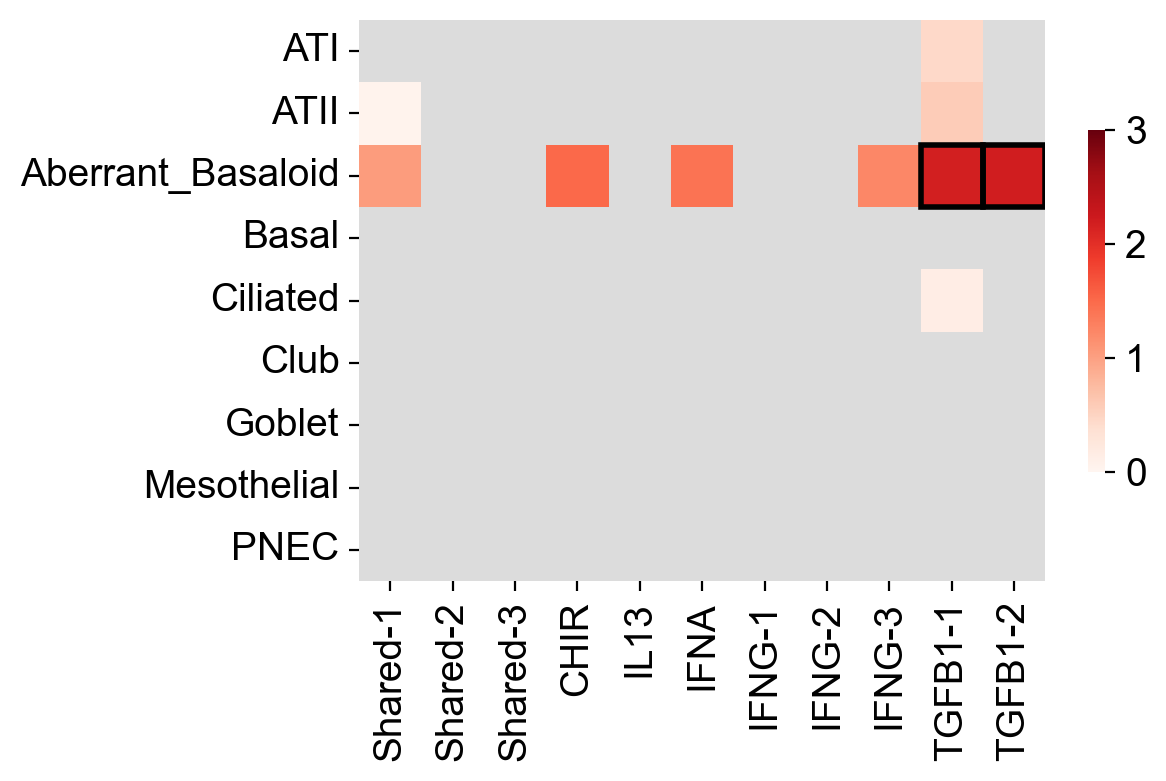

In [12]:
# subset signifant differences and fc > 0
fc_plot_median = median_fc[(median_pval_corr<0.05)]

# initialize plot
pl.figure(figsize = (fc_plot_median.shape[1]/2,fc_plot_median.shape[0]/2))

# plot grey region
sn.heatmap(-fc_plot_median.isnull(),  xticklabels=False, yticklabels = False,
              cmap = 'Greys', vmax = 1, vmin = -0.3, cbar=False)

# plot FC
g=sn.heatmap(fc_plot_median, cmap = 'Reds' , vmax = 3, vmin = 0, square = True,
          xticklabels=fc_plot_median.columns, yticklabels=fc_plot_median.index, cbar_kws={"shrink": 0.5})

# add box around fold change greater than 2
add_boxes_bool = np.array((median_fc>2)&(median_pval_corr<0.05))
r,c = np.where(add_boxes_bool)

for i in range(r.shape[0]):
    g.add_patch(Rectangle((c[i], r[i]), 1, 1, fill=False, edgecolor='black', lw=2))


In [13]:
# save values on the plot:

fc_plot_median.to_csv('../../data/csv_txt_files/copd_heatmap_bootstrapped.csv', sep = ',')